In [1]:
cd("/Users/evanrussek/forage_jsp/analysis/")

using CSV
using DataFrames
using DataFramesMeta
using CategoricalArrays
using Gadfly
using MixedModels
using StatsBase
using Statistics
using TableView
import Cairo


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-2488638724503105345\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-3132624226646272284\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-2488638724503105345\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [3]:
data = CSV.read("data/run5_data.csv");
# add s_num to it as a factor, get number of subjects
data.s_num = groupindices(groupby(data,:subjectID));
data.subj = CategoricalArray(data.s_num);
n_subj = length(unique(data.subj));

# define travel keys - we checked before that 1 is easy, 2 is hard
travel_keys = unique(data.travel_key)
travel_key_easy = travel_keys[1];
travel_key_hard = travel_keys[2];

In [4]:
function clean_subj_data(s_data)
        # clean subject 1 data...
        s_data = @select(s_data,:round, :phase, :reward_obs,
                                :reward_true, :lag, :exit, :start_reward, :n_travel_steps,
                                :travel_key, :subjectID, :trial_num, :s_num, :correct_key)

        # compute pressnum column... is there as simpler way to do this?
        trial_press_num_df = by(s_data,:trial_num, df -> DataFrame(press_num = 1:nrow(df)))
        s_data.press_num = trial_press_num_df.press_num

        # change phase name, travel_key
        s_data = @byrow! s_data begin
                if :phase == "Harvest"
                :phase = "HARVEST"
                end
                @newcol travel_key_cond::Array{String,1}
                if :travel_key == travel_key_hard
                        :travel_key_cond = "HARD"
                else
                        :travel_key_cond = "EASY"
                end
        end

        return s_data
end

clean_subj_data (generic function with 1 method)

In [5]:
# aggregate all clean data...
cdata = DataFrame();
for s = 1:n_subj
        global cdata
        s_data = @where(data,:subj .== s)
        cdata = vcat(cdata,clean_subj_data(s_data))
end


In [6]:
head(cdata)

┌ Warning: `head(df::AbstractDataFrame)` is deprecated, use `first(df, 6)` instead.
│   caller = top-level scope at In[6]:1
└ @ Core In[6]:1


,round,phase,reward_obs,reward_true,lag,exit,start_reward,n_travel_steps
,Int64,String,Float64⍰,Float64⍰,Float64,Float64⍰,Int64,Int64
1,1,TRAVEL,missing,missing,1769.67,missing,60,16
2,1,TRAVEL,missing,missing,187.805,missing,60,16
3,1,TRAVEL,missing,missing,173.26,missing,60,16
4,1,TRAVEL,missing,missing,121.57,missing,60,16
5,1,TRAVEL,missing,missing,359.97,missing,60,16
6,1,TRAVEL,missing,missing,313.64,missing,60,16


In [ ]:
# let's get the # of rounds for each subject


In [7]:
## Compute exit thresholds for each round/trial/subj/group
## function to compute exit for each round in a trial's data...
function get_trial_exits(trial_data)
        last_phase = trial_data.phase[end]
        if (last_phase == "HARVEST")
                last_round = trial_data.round[end]
                trial_data = @where(trial_data, :round .!= last_round)
        end

        trial_data = @where(trial_data, .&(:phase .== "HARVEST", missing .!== :reward_obs))

        if size(trial_data,1) > 0
                exit_tbl = by(trial_data, :round,
                        last_reward = :reward_obs => last,
                        #trial_num = :trial_num => first,
                        phase = :phase => first,
                        start_reward = :start_reward => first,
                        travel_key_cond = :travel_key_cond => first
                        )
        else
                exit_tbl = DataFrame(last_reward = [],
                        #trial_num = [],
                        phase = [],
                        start_reward = [],
                        travel_key_cond = [],
                        round = [])
        end
        return exit_tbl
end

get_trial_exits (generic function with 1 method)

In [8]:
# exit_data for each round for each trial for each subject
round_exit_data = by(cdata, [:s_num, :trial_num], df -> get_trial_exits(df));

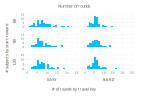

In [9]:
# get number of rounds for each subject...
rc_df = by(round_exit_data, [:s_num, :start_reward, :travel_key_cond, :phase], 
    df -> DataFrame(round_count = size(df,1)));


# let's make a histogram of round_counts by condition...
nr_plot = plot(sort(rc_df, :start_reward), x=:round_count, xgroup = :travel_key_cond, ygroup = :start_reward,
    Geom.subplot_grid(Geom.histogram),
    Guide.xlabel("# of rounds by travel key"),
    Guide.ylabel("# subjects by start reward"),
    Guide.title("Number of rounds"))

# save this plot...
draw(PNG("plots/n_round_hist.png", 4inch, 4inch), nr_plot)

nr_plot

In [10]:
# for each subject get the minimum number of rounds completed accross the conditions
min_round_subj_df = by(rc_df, :s_num, df -> DataFrame(min_rounds = minimum(df.round_count)));
round_exit_data = join(round_exit_data,min_round_subj_df, on = :s_num);
first(round_exit_data,6)



,s_num,trial_num,round,last_reward,phase,start_reward,travel_key_cond,min_rounds
,Int64⍰,Int64,Any,Any,Any,Any,Any,Int64
1,1,1,1,30.5686,HARVEST,60,EASY,7
2,1,1,2,24.3404,HARVEST,60,EASY,7
3,1,1,3,18.3757,HARVEST,60,EASY,7
4,1,1,4,24.2327,HARVEST,60,EASY,7
5,1,1,5,20.2626,HARVEST,60,EASY,7
6,1,1,6,22.6411,HARVEST,60,EASY,7


In [11]:
# make a function to make the group exit data for a specific round...
function make_group_exit_data_round(round_exit_data, round_number)
    first_round_exit = @where(round_exit_data, :round.==round_number);
    #head(first_round_exit)
    # exit data for each trial, for each subject
    fr_trial_exit_data = by(first_round_exit, [:s_num,:start_reward,:travel_key_cond],
                            exit_thresh = :last_reward => mean,
                            trial_num = :trial_num => first,
                            );
    # exit data for each trial, aggregated over subjects
    group_exit_data = by(fr_trial_exit_data, [:start_reward, :travel_key_cond],
                    df -> DataFrame(
                            exit_thresh = mean(df[:exit_thresh]),
                            exit_sem = std(df[:exit_thresh])/sqrt(nrow(df)),
                            ))
    return group_exit_data
end



make_group_exit_data_round (generic function with 1 method)

┌ Warning: `setproperty!(df::DataFrame, col_ind::Symbol, v)` is deprecated, use `df[!, col_ind] .= v` instead.
│   caller = top-level scope at In[88]:10
└ @ Core In[88]:10


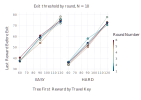

In [88]:
###### want to alter this so that we only include subjects who completed # many rounds for each
# remove subjects from round_exit_data with less then n rounds
for n = 2:6
    round_exit_data_filt = @where(round_exit_data, :min_rounds .>= n);
    n_subj = length(unique(round_exit_data_filt.s_num))

    all_round_group_exit_data = DataFrame();
    for r_idx in 1:n
        round_group_exit_data = make_group_exit_data_round(round_exit_data_filt,r_idx);
        round_group_exit_data.round = r_idx;
        all_round_group_exit_data = [all_round_group_exit_data; round_group_exit_data];
    end

    #all_round_group_exit_data = vcat(all_round_group_exit_data);

    et_by_round = plot(all_round_group_exit_data, 
            x =:start_reward, y =:exit_thresh, color = :round, xgroup=:travel_key_cond,
            Geom.subplot_grid(Geom.line, Geom.point),
            Guide.ylabel("Last Reward Before Exit"),
            Guide.xlabel("Tree First Reward by Travel Key"),
            Guide.title(string("Exit threshold by round, N = ", n_subj)),
            Guide.colorkey(title="Round Number")
    )

    draw(PNG(string("plots/exit_by_round_",n,".png"), 4inch, 4inch), et_by_round)
end
et_by_round

In [57]:
# now do the same thing, but for lag

lag_data = @select(cdata, :s_num, :travel_key_cond, :start_reward,
 :phase, :trial_num, :lag, :correct_key, :round, :reward_true, :press_num)

#showtable(lag_data)

 ## remove first press
lag_data = by(lag_data, [:s_num, :trial_num, :round, :phase],
    df -> df[2:end,[:travel_key_cond, :start_reward, :lag,:press_num]]);
# add press number
lag_data = by(lag_data, [:s_num, :trial_num, :round, :phase],
        df -> @transform(df[:,[:travel_key_cond, :start_reward, :lag]], press_num_round = 1:nrow(df)));

# remove outliers
lag_data = by(lag_data, :s_num,
        df -> @where(df[:,[:trial_num, :round, :phase,
        :travel_key_cond, :start_reward, :lag, :press_num_round]], .&(:lag .< median(:lag) + 3*mad(:lag),
        :lag .> median(:lag) - 3*mad(:lag))));

# compute log lag
lag_data = @transform(lag_data, log_lag = log.(:lag));
lag_data.subj = CategoricalArray(lag_data.s_num);

lag_data = join(lag_data,min_round_subj_df, on = :s_num);

lag_data[1:4,6:end]

┌ Warning: the `normalize` keyword argument will be false by default in future releases: set it explicitly to silence this deprecation
│   caller = (::var"##899#262")(::Array{Float64,1}) at DataFramesMeta.jl:71
└ @ Main /Users/evanrussek/.julia/packages/DataFramesMeta/c88dH/src/DataFramesMeta.jl:71
┌ Warning: the `normalize` keyword argument will be false by default in future releases: set it explicitly to silence this deprecation
│   caller = (::var"##899#262")(::Array{Float64,1}) at DataFramesMeta.jl:71
└ @ Main /Users/evanrussek/.julia/packages/DataFramesMeta/c88dH/src/DataFramesMeta.jl:71


,start_reward,lag,press_num_round,log_lag,subj,min_rounds
,Int64,Float64,Int64,Float64,Categorical…⍰,Int64
1,60,187.805,1,5.2354,1,7
2,60,173.26,2,5.15479,1,7
3,60,121.57,3,4.80049,1,7
4,60,164.475,6,5.10276,1,7


In [71]:
function make_group_lag_data_round(this_lag_data, round_number, press_thresh)

    round_lag_data = @where(this_lag_data, .&(:round .== round_number,:press_num_round .< press_thresh));

    # remove from round_lag data the subjects who don't have at least n rounds

    # average lag by round
    round1_lag = by(round_lag_data,[:subj, :start_reward, :travel_key_cond, :round, :phase],
            df -> DataFrame(trial_num = first(df.trial_num),
                            lag = median(df.lag),
                            log_lag = mean(df.log_lag)))
    trial_lag_r1 = by(round1_lag, [:subj, :start_reward, :travel_key_cond, :phase],
            df -> DataFrame(trial_num = first(df.trial_num),
                            lag = median(df.lag),
                            log_lag = mean(df.log_lag)))

    # average accross subjects
    group_lag_r1 = by(trial_lag_r1, [:start_reward, :travel_key_cond, :phase],
            df -> DataFrame(trial_num = first(df.trial_num),
                            lag = median(df.lag),
                            log_lag = mean(df.log_lag),
                            log_lag_sem = std(df.log_lag)/sqrt(size(df,1))))
    return group_lag_r1
end


make_group_lag_data_round (generic function with 1 method)

┌ Warning: `setproperty!(df::DataFrame, col_ind::Symbol, v)` is deprecated, use `df[!, col_ind] .= v` instead.
│   caller = top-level scope at In[87]:11
└ @ Core In[87]:11


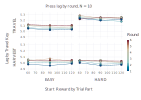

In [87]:

for n in 1:6
    #n = 1; # do this for round 1 and 2
    filt_lag_data = @where(lag_data, :min_rounds .>= n)

    n_subj = length(unique(filt_lag_data.s_num))

    all_round_group_lag_data = DataFrame();
    for r_idx in 1:n
        round_group_lag_data = make_group_lag_data_round(filt_lag_data,r_idx, 20);
        round_group_lag_data.round = r_idx;
        all_round_group_lag_data = [all_round_group_lag_data; round_group_lag_data];
    end

    # maybe we want 4 subplots - color should be the round number, 
    # col should be the phase, row should be the 

    #head(all_round_group_lag_data)

    l_by_round = plot(all_round_group_lag_data,
                x =:start_reward, y=:log_lag, color =:round, 
                xgroup=:travel_key_cond, ygroup=:phase,
                Geom.subplot_grid(Geom.line, Geom.point),
                Guide.title(string("Press lag by round, N = ", n_subj)),
                Guide.ylabel("Lag by Travel Key"),
                Guide.xlabel("Start Reward by Trial Part"),
                Guide.colorkey(title="Round")
                )

    draw(PNG(string("plots/lag_by_round_",n,".png"), 4inch, 4inch), l_by_round)
end


l_by_round
